In [ ]:
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay==0.2.*

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
!pip install gym
!pip install gym[box2d]
!pip install stable-baselines3[extra]
!pip install pygame

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

import gym
from gym.wrappers.monitoring.video_recorder import VideoRecorder

from IPython.display import HTML
from pyvirtualdisplay import Display
from base64 import b64encode
from stable_baselines3 import TD3

from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback

class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print(f"Saving new best model to {self.save_path}.zip")
                  self.model.save(self.save_path)

        return True




In [ ]:
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

env = gym.make("CarRacing-v0")
env = Monitor(env, log_dir)


In [ ]:
#Number of timesteps to train the model in
training_timesteps = 5000

# Separate evaluation env
eval_env = make_vec_env('CarRacing-v0')
# Use deterministic actions for evaluation
eval_callback = EvalCallback(eval_env, best_model_save_path='./logs/',
                             log_path='./logs/', eval_freq=500,
                             deterministic=True, render=False)

display = Display(visible=False, size=(1400, 900))
_ = display.start()

after_training = "after_training.mp4"
model = TD3("CnnPolicy", env, verbose=1, learning_rate=0.0003, batch_size = 64, buffer_size = 100)
video = VideoRecorder(env, after_training)
print(env.action_space)

callback = SaveOnBestTrainingRewardCallback(check_freq=500, log_dir=log_dir)
model.learn(total_timesteps=training_timesteps, callback=callback)

Using cuda device
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Box([-1.  0.  0.], [1. 1. 1.], (3,), float32)
Track generation: 1289..1615 -> 326-tiles track
Track generation: 1227..1538 -> 311-tiles track
Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: -35.38
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 1500
Best mean reward: -35.38 - Last mean reward per episode: -35.38
Track generation: 1211..1518 -> 307-tiles track
Num timesteps: 2000
Best mean reward: -35.38 - Last mean reward per episode: -59.63
Num timesteps: 2500
Best mean reward: -35.38 - Last mean reward per episode: -59.63
Track generation: 1182..1482 -> 300-tiles track
Num timesteps: 3000
Best mean reward: -35.38 - Last mean reward per episode: -67.64
Num timesteps: 3500
Best mean reward: -35.38 - Last mean reward per episode: -67.64
Track generation: 1193..1495 -> 302-tiles track
Num timesteps: 4000
Best mean reward: -35.38 - Last mean reward per e

In [ ]:
#Validation
obs = env.reset()
for i in range(10000):
  env.render()
  video.capture_frame()
  action, _states = model.predict(obs.copy(), deterministic=True)
  env.action_space.sample()
  # env.action_space.sample() produces either 0 (left) or 1 (right).
  obs, reward, done, info = env.step(action)
  #print("step", i, observation, reward, done, info)
  if done:
    obs = env.reset()
    break

video.close()
env.close()

Track generation: 1231..1543 -> 312-tiles track
Track generation: 1253..1571 -> 318-tiles track


In [ ]:
from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video
  at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [ ]:
from IPython.display import HTML
html = render_mp4(after_training)
HTML(html)

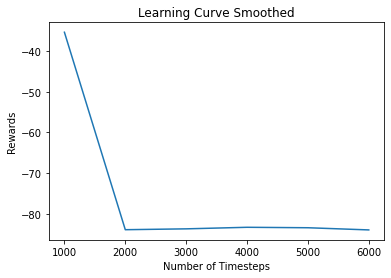

In [ ]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    #y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()

plot_results(log_dir)